# BitPredict Project: Forecasting Bitcoin prices based on historical data

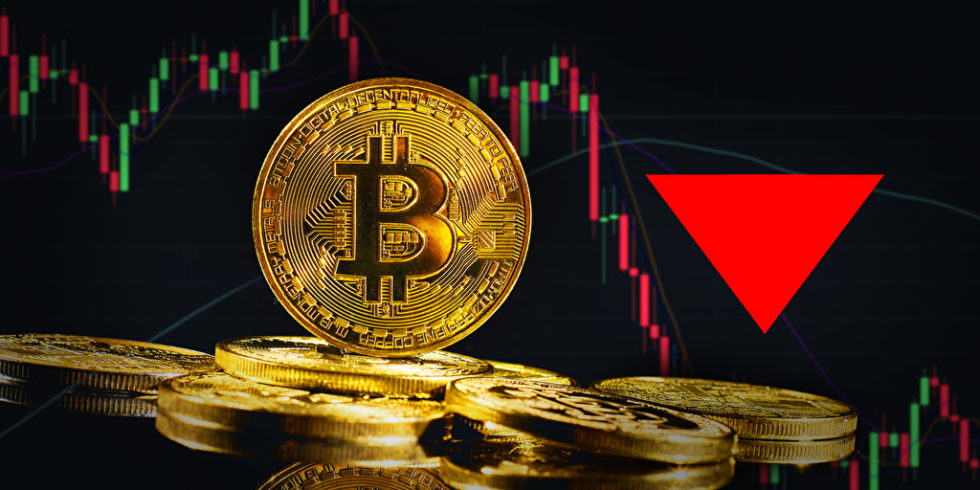

### General Information

In this project, I am going to be building a series of Deep Learning models in an attempt to predict the price of Bitcoin. The problem is framed as a **Time Series Regression**. To train my models, I will use the historical Bitcoin prices for the period from 2014-11-02 to 2021-10-10. The data are collected from https://www.coindesk.com/price/bitcoin/. 

Looking ahead, it's important to note, that all models (even rather complicated ones) were having a hard time beating a simple naïve model (i.e., a model which uses the previous timestep value to predict the next timestep value). This is a common problem to face when trying to forecast data with a strong temporal dependance (i.e. autocorrelated data). 

When considering application of a Time Series forecasting approach, one should be aware that the predictability of an event or a quantity depends on several factors including:

how well we understand the factors that contribute to it;
* how much data is available;
* how similar the future is to the past;
* whether the forecasts can affect the thing we are trying to forecast.

When forecasting cryptocurrency prices, hardly any of the conditions is satisfied (we do not even have enough data, for the whole crypto story begun only a decade ago). We have a very limited understanding of the factors that affect exchange rates (the most profound one is probably the human psychology), the future may well be different to the past if there is a financial crisis or some new financial regulations in one of the countries, and forecasts of the crypto market prices have a direct effect on the prices themselves. If there are well-publicised forecasts that the BTC prices will increase, then people will immediately adjust the price they are willing to pay and so the forecasts are self-fulfilling. In a sense, the exchange rates become their own forecasts. -> [Source](https://otexts.com/fpp3/what-can-be-forecast.html)

Having mentioned this, I still consider the problem as a good playground to learn some underlying concepts of using Deep Learning for Time Series Forecasting. These methods & techniques can be applied for more appropriate forecasting situations to create models that capture the genuine patterns and relationships which exist in the historical data.

I've structured this project as a sequence of experiments, in which I train different models and compare their validation results. I've used MAE, MAPE, MSE, MASE, and RMSE as [metrics](https://www.tensorflow.org/api_docs/python/tf/losses) to compare, whereas MAE is used as a loss function in all models. 

Below, I have included some relevant techniques that I learned and implemented during the project: 
* Using `tf.data` API for more computationally efficient data processing 
* Callbacks for saving the best model during training
* Framing a BTC prices forecasting problem in seq2seq terms and using Conv1D model
* Recurrent neural network to model sequential time series data
* Transforming the problem to multivariat time series problem by adding additional variable - *block reward size*
* Replicating the generic architecture of the [N-BEATS algorithm](https://arxiv.org/abs/1905.10437)
* Creating an ensemble: stacking models trained with different loss-functions together


I believe it is already apparent after all aforementioned about the random process forecasting, but I feel I should still put a disclaimer that **the predictions I've made here are not financial advice**, since the project will be publically available :)

### Importing necessary libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import csv
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import os
from sklearn.preprocessing import minmax_scale
from pandas.plotting import autocorrelation_plot

### Get & Analyse data

In [2]:
# get the data (https://www.coindesk.com/price/bitcoin/)
!gdown --id '1Llr-zdLX5hYSB9a4QU9fZZ63YQ1L1Hrh'

Downloading...
From: https://drive.google.com/uc?id=1Llr-zdLX5hYSB9a4QU9fZZ63YQ1L1Hrh
To: /content/BTC_USD_2014-11-02_2021-10-10-CoinDesk.csv
100% 168k/168k [00:00<00:00, 64.8MB/s]


In [3]:
# import with pandas to better analyse data
df = pd.read_csv('BTC_USD_2014-11-02_2021-10-10-CoinDesk.csv', 
                 parse_dates=['Date'],
                 index_col=['Date'])

In [4]:
# check a few first rows
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2014-11-02,BTC,325.22633,338.01050,338.12950,319.36700
2014-11-03,BTC,331.60083,325.22633,333.75983,319.04350
2014-11-04,BTC,324.71833,331.60083,332.75133,323.06333
2014-11-05,BTC,332.45666,324.71833,335.81166,320.93333
2014-11-06,BTC,336.58500,332.45666,341.49000,328.56166


In [5]:
# check a few last rows
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-10-06,BTC,51459.092821,49225.684134,51886.074041,49054.181527
2021-10-07,BTC,55029.874319,51480.041267,55321.762496,50419.064462
2021-10-08,BTC,53770.277058,55297.049343,55306.199757,53366.514908
2021-10-09,BTC,54203.298314,53761.717440,56049.816899,53626.710883
2021-10-10,BTC,54854.876457,53941.997471,55360.200776,53683.350737


In [6]:
# check data information
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2520 entries, 2014-11-02 to 2021-10-10
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2520 non-null   object 
 1   Closing Price (USD)  2520 non-null   float64
 2   24h Open (USD)       2520 non-null   float64
 3   24h High (USD)       2520 non-null   float64
 4   24h Low (USD)        2520 non-null   float64
dtypes: float64(4), object(1)
memory usage: 118.1+ KB


We've collected the historical price of Bitcoin for the past ~8 years but there's only 2520 total samples.

This data problem is common for Time Series analysis. Often, the number of samples isn't as large as other kinds of data.

In [7]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2014-11-02,325.22633
2014-11-03,331.60083
2014-11-04,324.71833
2014-11-05,332.45666
2014-11-06,336.58500


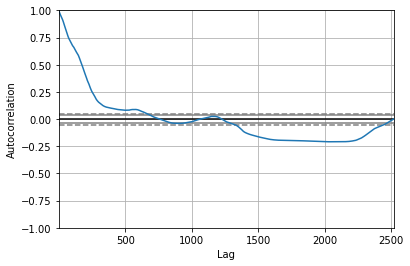

In [8]:
autocorrelation_plot(bitcoin_prices['Price'].to_numpy());

The quick check for **autocorrelation** reveals that our data show rather strong temporal dependence, which means that we are most likely dealing with a *random walk process* here. This kind of data is very hard to predict using known statistical methods. Read [this article](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424) for more information.

For educational purpose though, we will still try to apply various Deep Learning techniques to try to beat a simple persistance model.

In [9]:
bitcoin_prices.describe()

,Price
count,2520.000000
mean,9458.050984
std,13676.612440
min,193.351100
25%,603.407180
50%,5848.335956
75%,9738.884432
max,63346.789035


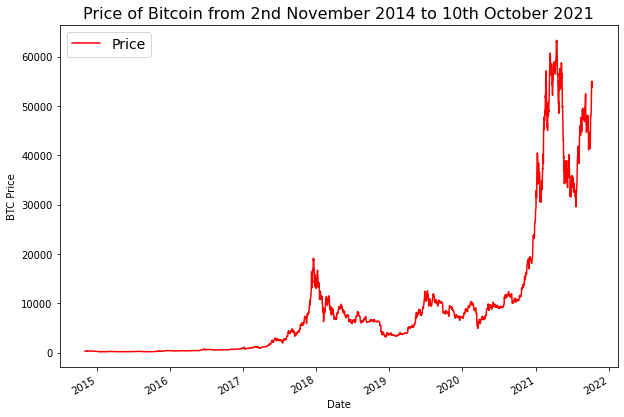

In [10]:
bitcoin_prices.plot(c='red', figsize=(10, 7));
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 2nd November 2014 to 10th October 2021", fontsize=16)
plt.legend(fontsize=14);

In [11]:
# Importing and formatting historical Bitcoin data with Python
timesteps = []
btc_price = []
with open('/content/BTC_USD_2014-11-02_2021-10-10-CoinDesk.csv', 'r') as f:
  csv_reader = csv.reader(f, delimiter=',') # read in the target CSV
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], '%Y-%m-%d')) # get the dates as dates (not strings), strptime = string parse time
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2014, 11, 2, 0, 0),
  datetime.datetime(2014, 11, 3, 0, 0),
  datetime.datetime(2014, 11, 4, 0, 0),
  datetime.datetime(2014, 11, 5, 0, 0),
  datetime.datetime(2014, 11, 6, 0, 0),
  datetime.datetime(2014, 11, 7, 0, 0),
  datetime.datetime(2014, 11, 8, 0, 0),
  datetime.datetime(2014, 11, 9, 0, 0),
  datetime.datetime(2014, 11, 10, 0, 0),
  datetime.datetime(2014, 11, 11, 0, 0)],
 [325.22633,
  331.60083,
  324.71833,
  332.45666,
  336.585,
  346.775,
  344.81166,
  343.065,
  358.50166,
  368.07666])

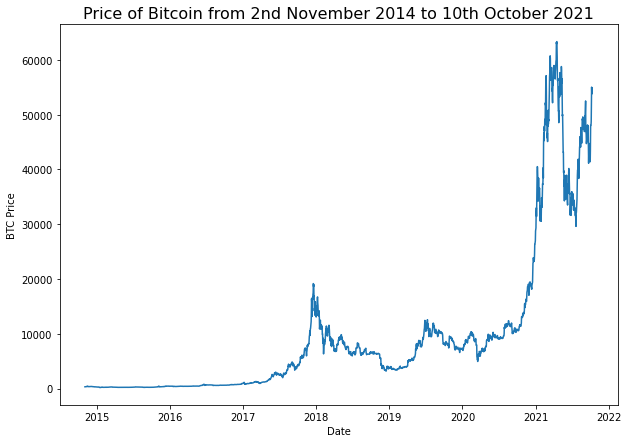

In [12]:
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 2nd November 2014 to 10th October 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price");

### Create train & test sets for time series

In [13]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2014-11-02T00:00:00.000000000', '2014-11-03T00:00:00.000000000',
        '2014-11-04T00:00:00.000000000', '2014-11-05T00:00:00.000000000',
        '2014-11-06T00:00:00.000000000', '2014-11-07T00:00:00.000000000',
        '2014-11-08T00:00:00.000000000', '2014-11-09T00:00:00.000000000',
        '2014-11-10T00:00:00.000000000', '2014-11-11T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([325.22633, 331.60083, 324.71833, 332.45666, 336.585  , 346.775  ,
        344.81166, 343.065  , 358.50166, 368.07666]))

In [14]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2016, 504, 2016, 504)

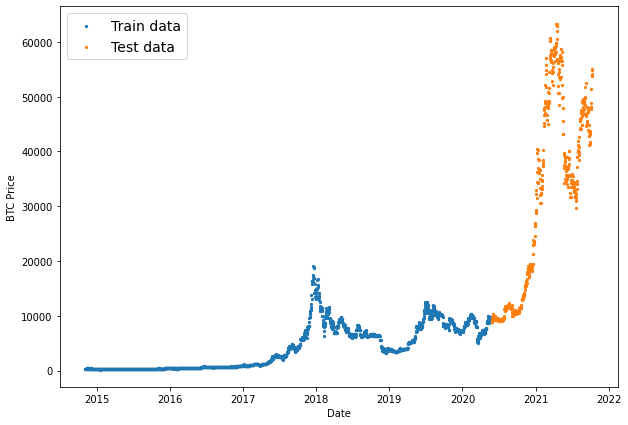

In [15]:
# Plot our splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

In [16]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

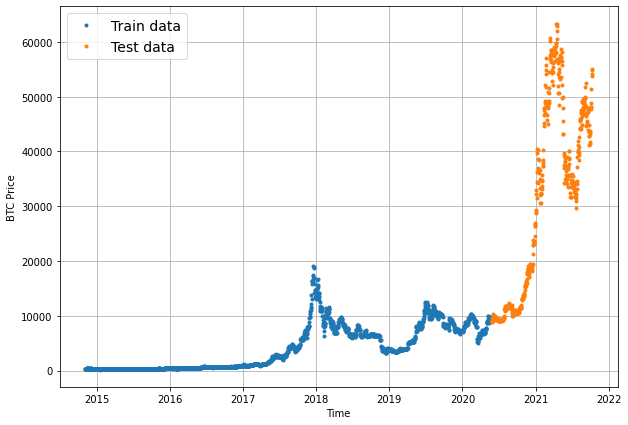

In [17]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')

Now, as we finished importing; analysing & preparing our historical Bitcoin prices data, we can start with modelling. 

For this project, we are going to run the following experiments:

0.	Naïve model (baseline)	
1.	Dense model (horizon = 1, window = 7)	
2.	Same architecture as 1 (horizon = 1, window = 30)	
3.	Same architecture as 1 (horizon = 7, window = 30)	
4.	Conv1D (horizon = 1, window = 7)		
5.	LSTM (horizon = 1, window = 7)		
6.	Same architecture as 1 but with multivariate data (horizon = 1, window = 7)
7.	N-BEATs Algorithm (horizon = 1, window = 7)	
8.	Ensemble (multiple models optimized on different loss functions) (horizon = 1, window = 7)
9.	Future prediction model (model to predict future values) (horizon = 1, window = 7)
10.	Same as 1 (but with *turkey data* introduced) (horizon = 1, window = 7)

### Model 0: Naïve forecast (baseline)

One of the most common baseline models for time series forecasting, the naïve model (also called the naïve forecast), requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

$$\hat{y}_{t} = y_{t-1}$$

In an open system (like a stock market or crypto market), you'll often find beating the naïve forecast with any kind of model is quite hard.

In [18]:
# creat a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([ 9048.71511916,  8905.78160454,  8835.72722404,  9112.97917559,
         9507.52466466,  9425.28186919,  9688.32439037,  9427.67008414,
        10268.58198473,  9516.13544309]),
 array([41412.6147362 , 43718.37774674, 47797.70403327, 48083.43725556,
        48085.04798091, 48794.21023815, 51459.09282091, 55029.874319  ,
        53770.27705841, 54203.29831439]))

In [19]:
y_test[-10:]

array([43718.37774674, 47797.70403327, 48083.43725556, 48085.04798091,
       48794.21023815, 51459.09282091, 55029.874319  , 53770.27705841,
       54203.29831439, 54854.87645698])

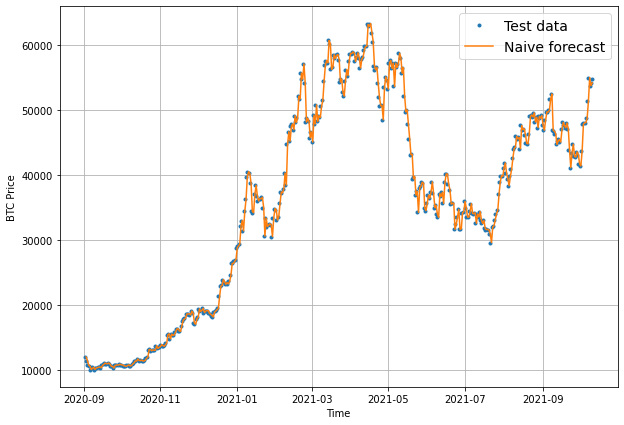

In [20]:
# plot naive forecast
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, start=100, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format='-', start=100, label='Naive forecast')

When we zoom in we see the naïve forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

### Evaluate Time Series Model

The main thing we will be evaluating is: how do our model's predictions (`y_pred`) compare against the actual values (`y_true` or ground truth values)?

Because we are working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecastin):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean squared error
* MAPE - mean absolute percentage error
* sMAPE - symmetric mean absolute percentage error
* MASE - mean absolute scaled error
* Huber loss (less sensitive to *outliers* in data than the squared error loss)

For all of the above metrics: **lower is better**.



In [21]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return np.round(mae / mae_naive_no_season, 4)

In practice, if we've created the function correctly, the naïve model should achieve an MASE of 1 (or very close to 1). Any model worse than the naïve forecast will achieve an MASE of >1 and any model better than the naïve forecast will achieve an MASE of <1.

In [22]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast)

0.9983

In [23]:
# create evaluation function
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = tf.convert_to_tensor(mean_absolute_scaled_error(y_true, y_pred), dtype=tf.float32)

  # account for different siyed metrics (for longer horizons we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {'mae': mae.numpy(),
          'mse': mse.numpy(),
          'rmse': rmse.numpy(),
          'mape': mape.numpy(),
          'mase': mase.numpy()}

In [24]:
naive_results = evaluate_preds(y_true=y_test[1:], 
                               y_pred=naive_forecast)
naive_results

{'mae': 897.2354,
 'mape': 2.6299334,
 'mase': 0.9983,
 'mse': 1978848.4,
 'rmse': 1406.7155}

### Format Data: Windowing our dataset

``` 
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
``` 

``` 
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
``` 

In [25]:
btc_price[:7], btc_price[7]

([325.22633, 331.60083, 324.71833, 332.45666, 336.585, 346.775, 344.81166],
 343.065)

In [26]:
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of BTC data to make the prediction

In [27]:
# create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [28]:
# test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


Now we need a way to make windows for an entire time series.

Let's write a function which:

1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses NumPy indexing to create a 2D of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6, 7],
[1, 2, 3, 4, 5, 6, 7, 8],
[2, 3, 4, 5, 6, 7, 8, 9]]
```
3. Uses the 2D array of multuple window steps to index on a target series
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon

In [29]:
# create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [30]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2513, 2513)

In [31]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Horizon: {full_labels[i-3]}")

Window: [43718.37774674 47797.70403327 48083.43725556 48085.04798091
 48794.21023815 51459.09282091 55029.874319  ] -> Horizon: [53770.27705841]
Window: [47797.70403327 48083.43725556 48085.04798091 48794.21023815
 51459.09282091 55029.874319   53770.27705841] -> Horizon: [54203.29831439]
Window: [48083.43725556 48085.04798091 48794.21023815 51459.09282091
 55029.874319   53770.27705841 54203.29831439] -> Horizon: [54854.87645698]


You can find a function which achieves similar results to the ones we implemented above at `tf.keras.preprocessing.timeseries_dataset_from_array()`. Just like ours, it takes in an array and returns a windowed dataset. It has the benefit of returning data in the form of a `tf.data.Dataset` instance (we'll see how to do this with our own data later).

In [32]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [33]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
train_windows[:5], train_labels[:5]

(array([[325.22633, 331.60083, 324.71833, 332.45666, 336.585  , 346.775  ,
         344.81166],
        [331.60083, 324.71833, 332.45666, 336.585  , 346.775  , 344.81166,
         343.065  ],
        [324.71833, 332.45666, 336.585  , 346.775  , 344.81166, 343.065  ,
         358.50166],
        [332.45666, 336.585  , 346.775  , 344.81166, 343.065  , 358.50166,
         368.07666],
        [336.585  , 346.775  , 344.81166, 343.065  , 358.50166, 368.07666,
         376.99666]]), array([[343.065  ],
        [358.50166],
        [368.07666],
        [376.99666],
        [442.10666]]))

### Make a modelling checkpoint

Because our model's performance will fluctuate from experiment to experiment, we'll want to make sure we're comparing apples to apples.

What I mean by this is in order for a fair comparison, we want to compare each model's best performance against each model's best performance.

To take of this, we'll implement a `ModelCheckpoint` callback.

The `ModelCheckpoint` callback will monitor our model's performance during training and save the best model to file by setting `save_best_only=True`.

Because we're going to be running multiple experiments, it makes sense to keep track of them by saving models to file under different names.

To do this, we'll write a small function to create a `ModelCheckpoint` callback which saves a model to specified filename.

In [34]:
# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

### Model 1: Dense model (window = 7, horizon = 1)

We're going to start by keeping it simple, model_1 will have:

* A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation
* An output layer with linear activation (or no activation)
* Adam optimizer and MAE loss function
* Batch size of 128 
* 100 epochs


In [35]:
# set random seed for as reproducible results as possible
tf.random.set_seed(29)

# create a model
model_1 = tf.keras.Sequential([
          layers.Dense(128, activation='relu'),
          layers.Dense(HORIZON, activation='linear')                     
], name='model_1_dense')

# compile the model
model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

# fit the model
hisory_1 = model_1.fit(x=train_windows,
                       y=train_labels,
                       epochs=100,
                       verbose=1,
                       batch_size=128,
                       validation_data=(test_windows, test_labels),
                       callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
16/16 [==============================] - 2s 46ms/step - loss: 3344.1943 - mae: 3344.1943 - val_loss: 8762.1113 - val_mae: 8762.1113
Epoch 2/100
16/16 [==============================] - 0s 31ms/step - loss: 563.6741 - mae: 563.6741 - val_loss: 2202.1980 - val_mae: 2202.1980
Epoch 3/100
16/16 [==============================] - 0s 31ms/step - loss: 273.8012 - mae: 273.8012 - val_loss: 1601.9304 - val_mae: 1601.9304
Epoch 4/100
16/16 [==============================] - 0s 31ms/step - loss: 226.7852 - mae: 226.7852 - val_loss: 1542.9617 - val_mae: 1542.9617
Epoch 5/100
16/16 [==============================] - 0s 32ms/step - loss: 217.3244 - mae: 217.3244 - val_loss: 1516.7692 - val_mae: 1516.7692
Epoch 6/100
16/16 [==============================] - 0s 32ms/step - loss: 212.8396 - mae: 212.8396 - val_loss: 1461.3130 - val_mae: 1461.3130
Epoch 7/100
16/16 [==============================] - 1s 39ms/step - loss: 208.7712 - mae: 208.7712 - val_loss: 1451.4724 - val_mae: 1451.4724
Epoc

In [36]:
# evaluate the model using test set
model_1.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 2ms/step - loss: 960.6307 - mae: 960.6307


[960.6307373046875, 960.6307373046875]

In [37]:
# load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 2ms/step - loss: 913.9969 - mae: 913.9969


[913.9969482421875, 913.9969482421875]

We've trained a model and evaluated the it on the test data, but the project we're working on is called BitPredict so how do you think we could use our model to make predictions?

Since we're going to be running more modelling experiments, let's write a function which:

1. Takes in a trained model (just like `model_1`)
2. Takes in some input data (just like the data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions

In [38]:
def make_preds(model, input_data):
  '''
  Uses model to make predictions on input_data
  '''
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [39]:
# make predictions
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(503, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([ 9072.132,  8947.41 ,  8836.374,  9037.058,  9424.005,  9473.13 ,
         9682.038,  9512.815, 10101.029,  9711.895], dtype=float32)>)

In [40]:
# evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)

model_1_results

{'mae': 913.9969,
 'mape': 2.680575,
 'mase': 1.017,
 'mse': 2045334.9,
 'rmse': 1430.152}

In [41]:
naive_results

{'mae': 897.2354,
 'mape': 2.6299334,
 'mase': 0.9983,
 'mse': 1978848.4,
 'rmse': 1406.7155}

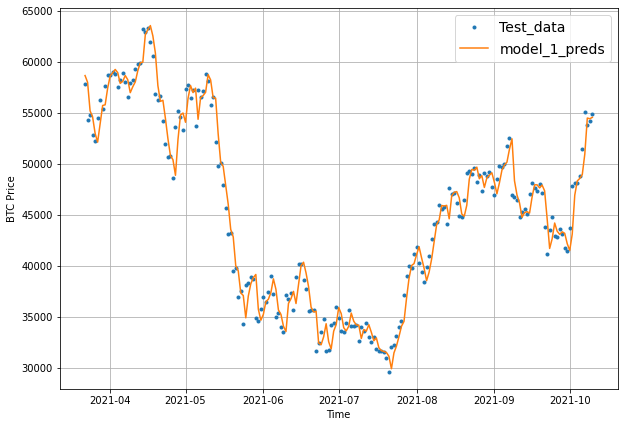

In [42]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

### Model 2: Dense (window = 30, horizon = 1)

We'll keep the previous model architecture but use a window size of 30.

In [43]:
HORIZON = 1
WINDOW_SIZE = 30

In [44]:
# make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

In [45]:
len(full_windows), len(full_labels)

(2490, 2490)

In [46]:
# make train & test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=.2)

In [47]:
tf.random.set_seed(29)

# create a model
model_2 = tf.keras.Sequential([
          layers.Dense(128, activation='relu'),
          layers.Dense(HORIZON)                    
], name='model_2_dense')

# compile the model
model_2.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

# fit the model
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: mod

In [48]:
# evaluate mode_2 on test data
model_2.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 2ms/step - loss: 983.0405 - mae: 983.0405


[983.04052734375, 983.04052734375]

In [49]:
model_2 = tf.keras.models.load_model('model_experiments/model_2_dense/')
model_2.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 2ms/step - loss: 965.1266 - mae: 965.1266


[965.1265869140625, 965.1265869140625]

In [50]:
# get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

In [51]:
# evaluate results for model_2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 965.1265,
 'mape': 2.7972221,
 'mase': 1.0657,
 'mse': 2206056.0,
 'rmse': 1485.2798}

In [52]:
model_1_results

{'mae': 913.9969,
 'mape': 2.680575,
 'mase': 1.017,
 'mse': 2045334.9,
 'rmse': 1430.152}

It looks like `model_2` performs worse than the naïve model as well as `model_1`!

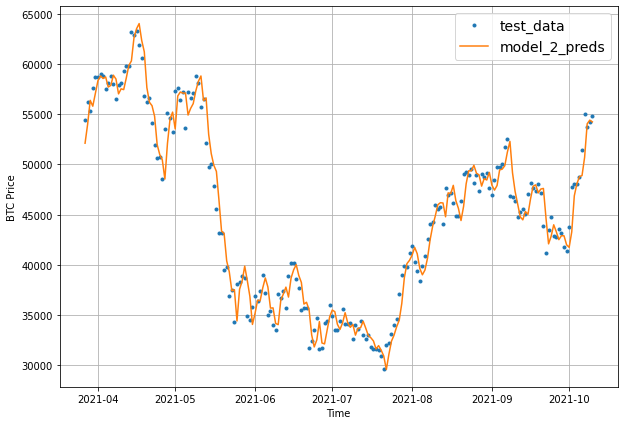

In [53]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

### Model 3: Dense (window = 30, horizon = 7)

Let's try and predict 7 days ahead given the previous 30 days.

In [54]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE,
                                         horizon=HORIZON)

len(full_windows), len(full_labels)

(2484, 2484)

In [55]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                               labels=full_labels,
                                                                               test_split=.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1987, 497, 1987, 497)

In [56]:
tf.random.set_seed(29)

# create model
model_3 = tf.keras.Sequential([
          layers.Dense(128, activation='relu'),
          layers.Dense(HORIZON)                     
], name='model_3_dense')

# compile the model
model_3.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# fit the model
model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: mod

In [57]:
# evaluate the model 3 on the test data
model_3.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 2ms/step - loss: 2035.5128


2035.5128173828125

In [58]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 2ms/step - loss: 2006.1785


2006.178466796875

In this case, the error will be higher because we're predicting 7 steps at a time.

This makes sense though because the further you try and predict, the larger your error will be (think of trying to predict the weather 7 days in advance).

In [59]:
# make predictions with model_3
model_3_preds = make_preds(model_3,
                           input_data=test_windows)

model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9366.85  , 9267.064 , 9342.658 , 9118.382 , 9221.371 , 9151.111 ,
        9060.53  ],
       [9062.26  , 9157.101 , 9127.423 , 8901.335 , 9144.643 , 8942.728 ,
        8704.452 ],
       [8841.742 , 8986.774 , 8943.834 , 8754.545 , 8984.565 , 8623.964 ,
        8547.566 ],
       [8986.358 , 9099.7   , 8950.072 , 8916.626 , 8778.6   , 8819.375 ,
        8904.259 ],
       [9341.559 , 9214.249 , 9377.664 , 9252.418 , 8968.726 , 9146.168 ,
        9273.6045]], dtype=float32)>

In [60]:
# get model 3 results
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)

In [61]:
model_3_results

{'mae': 2006.1785,
 'mape': 5.7590218,
 'mase': 2.2283,
 'mse': 9856291.0,
 'rmse': 2303.6694}

In [62]:
X_test.shape

(504,)

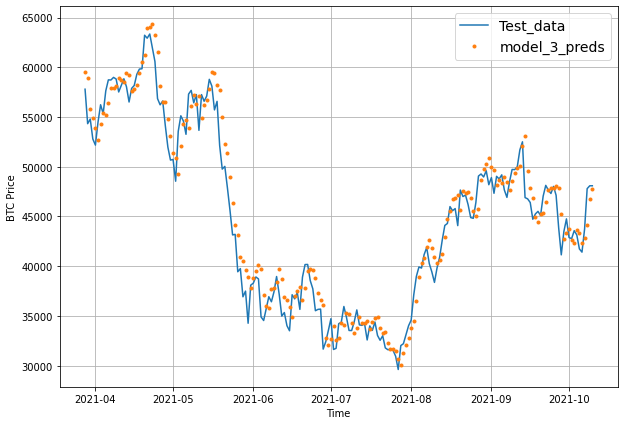

In [63]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], 
                 start=offset, format='-', label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, 1), start=offset, 
                 label="model_3_preds")

Which of our models is performing best so far?

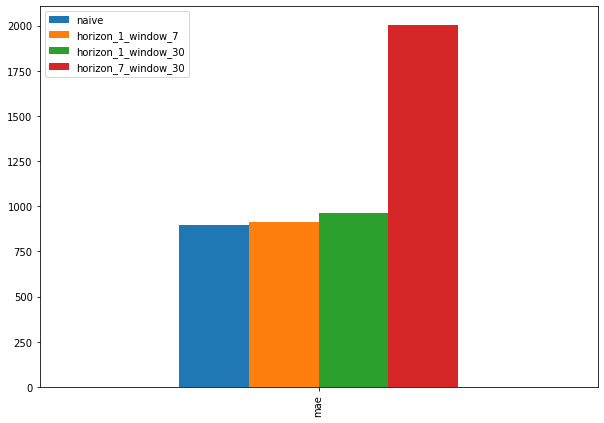

In [64]:
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

Woah, our naïve model is performing best (it's very hard to beat a naïve model in open systems) but the dense model with a horizon of 1 and a window size of 7 looks to be performing cloest.

Because of this, let's use HORIZON=1 and WINDOW_SIZE=7 for our next series of modelling experiments (in other words, we'll use the previous week of Bitcoin prices to try and predict the next day).

### Model 4: Conv1D

Framing Bitcoin forecasting in seq2seq (sequence to sequence) terms. Using a window size of 7 and a horizon of one results in a **many to one problem**. Using a window size of >1 and a horizon of >1 results in a **many to many problem**.

In [65]:
HORIZON = 1
WINDOW_SIZE = 7 # use previous week worth date

In [66]:
# create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

In [67]:
# create train-test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

To use a Conv1D layer, we need an input shape of (batch_size, timesteps, input_dim)

In [68]:
# check data input shape
train_windows[0].shape

(7,)

In [69]:
# before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([325.22633, 331.60083, 324.71833, 332.45666, 336.585  , 346.775  ,
       344.81166])>

In [70]:
# add an extra dimension for timesteps
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))

In [71]:
# test out our lambda layer
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[325.22632]
 [331.60083]
 [324.71832]
 [332.45667]
 [336.585  ]
 [346.775  ]
 [344.81165]]


In [72]:
tf.random.set_seed(29)
# create Conv1D
model_4 = tf.keras.Sequential([
          layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
          layers.Conv1D(filters=256, kernel_size=WINDOW_SIZE, strides=2, padding='causal', activation='relu'),
          layers.Dense(HORIZON)                     
], name='model_4_conv1D')

# compile the model
model_4.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# fit
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets wr

In [73]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 256)            12800     
                                                                 
 dense_6 (Dense)             (None, 1, 1)              257       
                                                                 
Total params: 13,057
Trainable params: 13,057
Non-trainable params: 0
_________________________________________________________________


In [74]:
# load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 2ms/step - loss: 912.7732


912.773193359375

In [75]:
# make predictions
model_4_preds = make_preds(model_4, test_windows)

In [76]:
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 912.77313,
 'mape': 2.6688364,
 'mase': 1.0156,
 'mse': 2049929.6,
 'rmse': 1431.7574}

In [77]:
model_1_results

{'mae': 913.9969,
 'mape': 2.680575,
 'mase': 1.017,
 'mse': 2045334.9,
 'rmse': 1430.152}

Awesome! With our Conv1D model, we finally managed to beat our naive model's results!

### Model 5: RNN (LSTM)

Once again, one of the most important steps for the LSTM model will be getting our data into the right shape.

The `tf.keras.layers.LSTM()` layer takes a tensor with `[batch, timesteps, feature]` dimensions.

As mentioned earlier, the `batch` dimension gets taken care of for us but our data is currently only has the feature dimension (`WINDOW_SIZE`).

To fix this, just like we did with the Conv1D model, we can use a `tf.keras.layers.Lambda()` layer to adjust the shape of our input tensors to the LSTM layer.

In [78]:
tf.random.set_seed(29)

# build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name='model_5_LSTM')

# compile
model_5.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# fit the model
model_5.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
 8/16 [==============>...............] - ETA: 0s - loss: 4255.2354 INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 3s 146ms/step - loss: 3811.5417 - val_loss: 23233.4980
Epoch 2/100
12/16 [=====================>........] - ETA: 0s - loss: 2621.7329INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 120ms/step - loss: 2472.8669 - val_loss: 11327.5986
Epoch 3/100
12/16 [=====================>........] - ETA: 0s - loss: 721.9417 INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 116ms/step - loss: 684.0992 - val_loss: 3760.1174
Epoch 4/100
12/16 [=====================>........] - ETA: 0s - loss: 342.6262INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 114ms/step - loss: 330.7824 - val_loss: 2015.7723
Epoch 5/100
12/16 [=====================>........] - ETA: 0s - loss: 249.6458INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 141ms/step - loss: 246.2775 - val_loss: 1707.4835
Epoch 6/100
12/16 [=====================>........] - ETA: 0s - loss: 230.0403INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 117ms/step - loss: 235.1490 - val_loss: 1629.5924
Epoch 7/100
12/16 [=====================>........] - ETA: 0s - loss: 236.3814INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 121ms/step - loss: 233.1834 - val_loss: 1620.9440
Epoch 8/100
16/16 [==============================] - 0s 7ms/step - loss: 230.9884 - val_loss: 1626.1650
Epoch 9/100
12/16 [=====================>........] - ETA: 0s - loss: 230.0916INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 135ms/step - loss: 229.4651 - val_loss: 1584.3517
Epoch 10/100
16/16 [==============================] - 0s 6ms/step - loss: 227.4341 - val_loss: 1612.6757
Epoch 11/100
12/16 [=====================>........] - ETA: 0s - loss: 228.3297INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 118ms/step - loss: 226.6909 - val_loss: 1576.3872
Epoch 12/100
12/16 [=====================>........] - ETA: 0s - loss: 224.4594INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 117ms/step - loss: 225.1394 - val_loss: 1550.8267
Epoch 13/100
12/16 [=====================>........] - ETA: 0s - loss: 221.7131INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 132ms/step - loss: 225.5215 - val_loss: 1546.3103
Epoch 14/100
16/16 [==============================] - 0s 6ms/step - loss: 221.1394 - val_loss: 1602.2921
Epoch 15/100
12/16 [=====================>........] - ETA: 0s - loss: 207.1700INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 116ms/step - loss: 221.2708 - val_loss: 1505.0438
Epoch 16/100
11/16 [===================>..........] - ETA: 0s - loss: 225.2695INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 115ms/step - loss: 221.2389 - val_loss: 1491.0862
Epoch 17/100
12/16 [=====================>........] - ETA: 0s - loss: 220.6505INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 116ms/step - loss: 217.7753 - val_loss: 1476.2156
Epoch 18/100
16/16 [==============================] - 0s 6ms/step - loss: 215.5572 - val_loss: 1523.8096
Epoch 19/100
12/16 [=====================>........] - ETA: 0s - loss: 203.1935INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 141ms/step - loss: 213.0102 - val_loss: 1465.6547
Epoch 20/100
16/16 [==============================] - 0s 7ms/step - loss: 210.0645 - val_loss: 1467.7289
Epoch 21/100
16/16 [==============================] - ETA: 0s - loss: 207.5425INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 121ms/step - loss: 207.5425 - val_loss: 1444.6108
Epoch 22/100
12/16 [=====================>........] - ETA: 0s - loss: 213.6812INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 122ms/step - loss: 207.8448 - val_loss: 1407.5548
Epoch 23/100
11/16 [===================>..........] - ETA: 0s - loss: 200.8971INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 138ms/step - loss: 204.9492 - val_loss: 1391.9689
Epoch 24/100
12/16 [=====================>........] - ETA: 0s - loss: 197.6173INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 121ms/step - loss: 201.3455 - val_loss: 1386.6497
Epoch 25/100
16/16 [==============================] - 0s 6ms/step - loss: 200.2580 - val_loss: 1420.3435
Epoch 26/100
11/16 [===================>..........] - ETA: 0s - loss: 196.6252INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 120ms/step - loss: 198.5832 - val_loss: 1351.4957
Epoch 27/100
16/16 [==============================] - 0s 9ms/step - loss: 197.1688 - val_loss: 1378.8436
Epoch 28/100
16/16 [==============================] - ETA: 0s - loss: 193.0894INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 139ms/step - loss: 193.0894 - val_loss: 1323.0635
Epoch 29/100
16/16 [==============================] - 0s 6ms/step - loss: 193.8198 - val_loss: 1329.3492
Epoch 30/100
11/16 [===================>..........] - ETA: 0s - loss: 187.4036INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 119ms/step - loss: 187.6513 - val_loss: 1302.0814
Epoch 31/100
12/16 [=====================>........] - ETA: 0s - loss: 182.6267INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 116ms/step - loss: 184.6263 - val_loss: 1275.0125
Epoch 32/100
16/16 [==============================] - 0s 6ms/step - loss: 183.5193 - val_loss: 1287.1063
Epoch 33/100
16/16 [==============================] - 0s 7ms/step - loss: 180.3079 - val_loss: 1284.2729
Epoch 34/100
12/16 [=====================>........] - ETA: 0s - loss: 179.9648INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 137ms/step - loss: 177.5628 - val_loss: 1237.5463
Epoch 35/100
12/16 [=====================>........] - ETA: 0s - loss: 177.6085INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 116ms/step - loss: 176.4897 - val_loss: 1204.9740
Epoch 36/100
11/16 [===================>..........] - ETA: 0s - loss: 162.1174INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 119ms/step - loss: 172.7795 - val_loss: 1190.9235
Epoch 37/100
12/16 [=====================>........] - ETA: 0s - loss: 170.6510INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 139ms/step - loss: 172.2079 - val_loss: 1173.2440
Epoch 38/100
16/16 [==============================] - 0s 8ms/step - loss: 169.8619 - val_loss: 1196.4155
Epoch 39/100
11/16 [===================>..........] - ETA: 0s - loss: 166.7968INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 118ms/step - loss: 166.2174 - val_loss: 1154.6536
Epoch 40/100
16/16 [==============================] - 0s 6ms/step - loss: 164.1785 - val_loss: 1156.4873
Epoch 41/100
12/16 [=====================>........] - ETA: 0s - loss: 167.3256INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 120ms/step - loss: 162.3179 - val_loss: 1127.4259
Epoch 42/100
11/16 [===================>..........] - ETA: 0s - loss: 159.4080INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 137ms/step - loss: 160.2979 - val_loss: 1102.5485
Epoch 43/100
16/16 [==============================] - 0s 6ms/step - loss: 159.5895 - val_loss: 1112.0405
Epoch 44/100
10/16 [=================>............] - ETA: 0s - loss: 149.1840INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 120ms/step - loss: 156.2170 - val_loss: 1100.4398
Epoch 45/100
12/16 [=====================>........] - ETA: 0s - loss: 151.8971INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 116ms/step - loss: 155.6731 - val_loss: 1099.1393
Epoch 46/100
12/16 [=====================>........] - ETA: 0s - loss: 152.5199INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 115ms/step - loss: 152.6870 - val_loss: 1053.0991
Epoch 47/100
13/16 [=======================>......] - ETA: 0s - loss: 149.2781INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 142ms/step - loss: 151.2546 - val_loss: 1034.3573
Epoch 48/100
16/16 [==============================] - 0s 8ms/step - loss: 158.0582 - val_loss: 1173.4968
Epoch 49/100
16/16 [==============================] - 0s 8ms/step - loss: 165.6186 - val_loss: 1066.6226
Epoch 50/100
13/16 [=======================>......] - ETA: 0s - loss: 154.9811INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 117ms/step - loss: 154.4120 - val_loss: 1014.2346
Epoch 51/100
 9/16 [===============>..............] - ETA: 0s - loss: 153.6273INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 119ms/step - loss: 146.9228 - val_loss: 1011.4752
Epoch 52/100
12/16 [=====================>........] - ETA: 0s - loss: 151.9847INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 138ms/step - loss: 148.5683 - val_loss: 995.8171
Epoch 53/100
16/16 [==============================] - 0s 7ms/step - loss: 145.6545 - val_loss: 1012.2994
Epoch 54/100
16/16 [==============================] - 0s 8ms/step - loss: 147.7621 - val_loss: 1060.2246
Epoch 55/100
16/16 [==============================] - 0s 8ms/step - loss: 147.2074 - val_loss: 1038.3003
Epoch 56/100
16/16 [==============================] - 0s 6ms/step - loss: 150.7206 - val_loss: 1215.0059
Epoch 57/100
10/16 [=================>............] - ETA: 0s - loss: 160.4244INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 119ms/step - loss: 149.9619 - val_loss: 976.7474
Epoch 58/100
16/16 [==============================] - 0s 7ms/step - loss: 143.5048 - val_loss: 1018.0250
Epoch 59/100
16/16 [==============================] - 0s 6ms/step - loss: 147.6226 - val_loss: 999.4778
Epoch 60/100
11/16 [===================>..........] - ETA: 0s - loss: 142.7810INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 119ms/step - loss: 144.2476 - val_loss: 970.7720
Epoch 61/100
16/16 [==============================] - 0s 7ms/step - loss: 142.9838 - val_loss: 974.6638
Epoch 62/100
10/16 [=================>............] - ETA: 0s - loss: 139.9665INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 137ms/step - loss: 140.9256 - val_loss: 965.3582
Epoch 63/100
11/16 [===================>..........] - ETA: 0s - loss: 135.9980INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 119ms/step - loss: 140.2531 - val_loss: 949.9588
Epoch 64/100
16/16 [==============================] - 0s 9ms/step - loss: 139.5152 - val_loss: 992.7081
Epoch 65/100
 9/16 [===============>..............] - ETA: 0s - loss: 136.8337INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 118ms/step - loss: 142.9175 - val_loss: 945.4808
Epoch 66/100
16/16 [==============================] - 0s 6ms/step - loss: 141.4755 - val_loss: 1033.4565
Epoch 67/100
16/16 [==============================] - 0s 7ms/step - loss: 140.5452 - val_loss: 947.0750
Epoch 68/100
16/16 [==============================] - 0s 6ms/step - loss: 141.9276 - val_loss: 1087.3293
Epoch 69/100
16/16 [==============================] - 0s 7ms/step - loss: 150.3014 - val_loss: 1036.8636
Epoch 70/100
16/16 [==============================] - 0s 7ms/step - loss: 143.4885 - val_loss: 979.6754
Epoch 71/100
 9/16 [===============>..............] - ETA: 0s - loss: 144.3450INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 138ms/step - loss: 154.2235 - val_loss: 940.7873
Epoch 72/100
16/16 [==============================] - 0s 7ms/step - loss: 147.4536 - val_loss: 940.9108
Epoch 73/100
12/16 [=====================>........] - ETA: 0s - loss: 144.9439INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 116ms/step - loss: 138.7982 - val_loss: 936.0165
Epoch 74/100
16/16 [==============================] - 0s 7ms/step - loss: 140.9118 - val_loss: 1121.9443
Epoch 75/100
16/16 [==============================] - 0s 7ms/step - loss: 145.4337 - val_loss: 980.2805
Epoch 76/100
16/16 [==============================] - 0s 6ms/step - loss: 141.9472 - val_loss: 998.8513
Epoch 77/100
16/16 [==============================] - 0s 8ms/step - loss: 140.9556 - val_loss: 948.3079
Epoch 78/100
16/16 [==============================] - 0s 6ms/step - loss: 138.9379 - val_loss: 937.5767
Epoch 79/100
 9/16 [===============>..............] - ETA: 0s - loss: 132.1918INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 117ms/step - loss: 137.3623 - val_loss: 927.5150
Epoch 80/100
16/16 [==============================] - 0s 6ms/step - loss: 138.0464 - val_loss: 939.3697
Epoch 81/100
16/16 [==============================] - 0s 8ms/step - loss: 139.6076 - val_loss: 942.2300
Epoch 82/100
12/16 [=====================>........] - ETA: 0s - loss: 136.0484INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 116ms/step - loss: 139.3739 - val_loss: 925.1566
Epoch 83/100
16/16 [==============================] - 0s 7ms/step - loss: 146.5349 - val_loss: 931.7083
Epoch 84/100
16/16 [==============================] - 0s 8ms/step - loss: 141.5113 - val_loss: 939.7034
Epoch 85/100
12/16 [=====================>........] - ETA: 0s - loss: 147.2653INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 138ms/step - loss: 142.3170 - val_loss: 922.1526
Epoch 86/100
16/16 [==============================] - 0s 6ms/step - loss: 139.7757 - val_loss: 967.8402
Epoch 87/100
16/16 [==============================] - 0s 8ms/step - loss: 139.5793 - val_loss: 999.0165
Epoch 88/100
16/16 [==============================] - 0s 7ms/step - loss: 138.6042 - val_loss: 924.4497
Epoch 89/100
16/16 [==============================] - 0s 6ms/step - loss: 137.8501 - val_loss: 933.7892
Epoch 90/100
16/16 [==============================] - 0s 7ms/step - loss: 137.0334 - val_loss: 1000.4043
Epoch 91/100
12/16 [=====================>........] - ETA: 0s - loss: 138.9366INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 116ms/step - loss: 139.4509 - val_loss: 918.2631
Epoch 92/100
12/16 [=====================>........] - ETA: 0s - loss: 135.9514INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 117ms/step - loss: 137.7486 - val_loss: 917.8923
Epoch 93/100
16/16 [==============================] - 0s 7ms/step - loss: 137.2029 - val_loss: 926.6389
Epoch 94/100
16/16 [==============================] - 0s 6ms/step - loss: 137.3206 - val_loss: 939.2832
Epoch 95/100
16/16 [==============================] - 0s 7ms/step - loss: 139.9070 - val_loss: 1058.2892
Epoch 96/100
16/16 [==============================] - 0s 7ms/step - loss: 148.0905 - val_loss: 938.8124
Epoch 97/100
16/16 [==============================] - 0s 7ms/step - loss: 144.7911 - val_loss: 1057.8118
Epoch 98/100
16/16 [==============================] - 0s 7ms/step - loss: 141.6829 - val_loss: 942.7922
Epoch 99/100
11/16 [===================>..........] - ETA: 0s - loss: 134.3802INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


16/16 [==============================] - 2s 139ms/step - loss: 137.0102 - val_loss: 914.4362
Epoch 100/100
16/16 [==============================] - 0s 7ms/step - loss: 137.2906 - val_loss: 916.2113


In [79]:
# load in best version of model_5 & evaluate on the test data
model_5_results = tf.keras.models.load_model('model_experiments/model_5_LSTM')
model_5.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 2ms/step - loss: 916.2112


916.2112426757812

In [80]:
model_5_preds = make_preds(model_5, test_windows)
# evaluate model_5 predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)

In [81]:
model_5_results

{'mae': 916.2113,
 'mape': 2.6840875,
 'mase': 1.0194,
 'mse': 2054803.1,
 'rmse': 1433.4584}

### Make a multivariate time series

So far all of our models have barely kept up with the naïve forecast.

And so far all of them have been trained on a single variable (also called univariate time series): the historical price of Bitcoin.

If predicting the price of Bitcoin using the price of Bitcoin hasn't worked out very well, maybe giving our model more information may help.

For example, we could pass the [*Bitcoin block reward size*](https://www.investopedia.com/terms/b/block-reward.asp) to our model(s).

The *Bitcoin block reward size* is the number of Bitcoin someone receives from mining a Bitcoin block.

At its inception, the Bitcoin block reward size was 50.

But every four years or so, the Bitcoin block reward halves.

For example, the block reward size went from 50 (starting January 2009) to 25 on November 28 2012.

Let's encode this information into our time series data and see if it helps a model's performance.

In [82]:
# block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

We're going to get the days (indexes) for different block reward values.

This is important because if we're going to use multiple variables for our time series, they have to the same frequency as our original variable. For example, if our Bitcoin prices are daily, we need the block reward values to be daily as well.

In [83]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(615, 2017)

In [84]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2014-11-02,325.22633,25
2014-11-03,331.60083,25
2014-11-04,324.71833,25
2014-11-05,332.45666,25
2014-11-06,336.58500,25


In [85]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2021-10-06,51459.092821,6.25
2021-10-07,55029.874319,6.25
2021-10-08,53770.277058,6.25
2021-10-09,54203.298314,6.25
2021-10-10,54854.876457,6.25


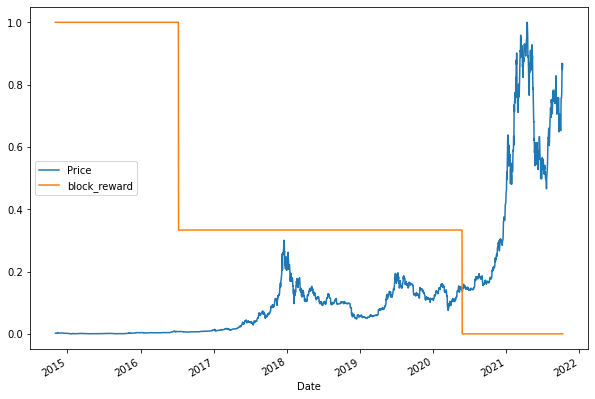

In [86]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.

scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

When we scale the block reward and the Bitcoin price, we can see the price goes up as the block reward goes down, perhaps this information will be helpful to our model's performance.

### Making a windowed dataset with pandas

Previously, we used some custom made functions to window our **univariate** time series.

However, since we've just added another variable to our dataset, these functions won't work.

Since our data is in a pandas DataFrame, we can leverage the `pandas.DataFrame.shift()` method to create a windowed **multivariate** time series.

The `shift()` method offsets an index by a specified number of periods.

In [87]:
# setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [88]:
# make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f'Price+{i+1}'] = bitcoin_prices_windowed['Price'].shift(periods=i+1)

bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-11-02,325.22633,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-03,331.60083,25,325.22633,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-04,324.71833,25,331.60083,325.22633,NaN,NaN,NaN,NaN,NaN
2014-11-05,332.45666,25,324.71833,331.60083,325.22633,NaN,NaN,NaN,NaN
2014-11-06,336.58500,25,332.45666,324.71833,331.60083,325.22633,NaN,NaN,NaN


Now that we've got a windowed dataset, let's separate features (`X`) from labels (`y`).

We'll also remove the NaN values using pandas `dropna()` method, this equivalent to starting our windowing function at `sample 0 (the first sample) + WINDOW_SIZE`.

In [89]:
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32) 
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-11-09,25.0,344.811646,346.774994,336.584991,332.456665,324.718323,331.600830,325.226318
2014-11-10,25.0,343.065002,344.811646,346.774994,336.584991,332.456665,324.718323,331.600830
2014-11-11,25.0,358.501648,343.065002,344.811646,346.774994,336.584991,332.456665,324.718323
2014-11-12,25.0,368.076660,358.501648,343.065002,344.811646,346.774994,336.584991,332.456665
2014-11-13,25.0,376.996674,368.076660,358.501648,343.065002,344.811646,346.774994,336.584991


In [90]:
# View labels
y.head()

Date
2014-11-09    343.065002
2014-11-10    358.501648
2014-11-11    368.076660
2014-11-12    376.996674
2014-11-13    442.106659
Name: Price, dtype: float32

In [91]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2010, 2010, 503, 503)

Training and test multivariate time series datasets made! Time to build a model.

### Model 6: Dense (multivariate time series)

To keep things simple, let's the `model_1` architecture and use it to train and make predictions on our multivariate time series data.

By replicating the `model_1` architecture we'll be able to see whether or not adding the block reward feature improves or detracts from model performance.

In [92]:
tf.random.set_seed(29)

# make multivariate time series model
model_6 = tf.keras.Sequential([
          layers.Dense(128, activation='relu'),
          layers.Dense(128, activation='relu'),
          layers.Dense(HORIZON)                     
], name='model_6_dense_multivariate')

# compile
model_6.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# fit the model
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
 1/16 [>.............................] - ETA: 4s - loss: 4272.6455INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


16/16 [==============================] - 1s 44ms/step - loss: 1460.3068 - val_loss: 1654.7361
Epoch 2/100
 1/16 [>.............................] - ETA: 0s - loss: 235.1466INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


16/16 [==============================] - 1s 36ms/step - loss: 364.3038 - val_loss: 1522.5548
Epoch 3/100
 1/16 [>.............................] - ETA: 0s - loss: 222.4286INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


16/16 [==============================] - 1s 36ms/step - loss: 232.1733 - val_loss: 1505.5348
Epoch 4/100
 1/16 [>.............................] - ETA: 0s - loss: 174.7493INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


16/16 [==============================] - 1s 37ms/step - loss: 198.4246 - val_loss: 1311.4385
Epoch 5/100
 1/16 [>.............................] - ETA: 0s - loss: 226.6476INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


16/16 [==============================] - 1s 55ms/step - loss: 185.7496 - val_loss: 1239.6324
Epoch 6/100
 1/16 [>.............................] - ETA: 0s - loss: 110.2177INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


16/16 [==============================] - 1s 36ms/step - loss: 175.3288 - val_loss: 1194.8074
Epoch 7/100
 1/16 [>.............................] - ETA: 0s - loss: 176.7138INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


16/16 [==============================] - 1s 36ms/step - loss: 169.6345 - val_loss: 1161.1633
Epoch 8/100
 1/16 [>.............................] - ETA: 0s - loss: 169.0256INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


16/16 [==============================] - 1s 35ms/step - loss: 159.9491 - val_loss: 1106.5884
Epoch 9/100
 1/16 [>.............................] - ETA: 0s - loss: 142.4266INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


16/16 [==============================] - 1s 36ms/step - loss: 160.9138 - val_loss: 1083.8403
Epoch 10/100
 1/16 [>.............................] - ETA: 0s - loss: 142.7175INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


16/16 [==============================] - 1s 37ms/step - loss: 157.8657 - val_loss: 1080.3904
Epoch 11/100
 1/16 [>.............................] - ETA: 0s - loss: 171.7489INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


16/16 [==============================] - 1s 37ms/step - loss: 156.9660 - val_loss: 1018.1682
Epoch 12/100
16/16 [==============================] - 0s 4ms/step - loss: 155.2635 - val_loss: 1038.2775
Epoch 13/100
16/16 [==============================] - 0s 3ms/step - loss: 158.7418 - val_loss: 1064.2267
Epoch 14/100
 1/16 [>.............................] - ETA: 0s - loss: 139.4079INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


16/16 [==============================] - 1s 36ms/step - loss: 145.9420 - val_loss: 988.2829
Epoch 15/100
 1/16 [>.............................] - ETA: 0s - loss: 115.2006INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


16/16 [==============================] - 1s 36ms/step - loss: 145.4611 - val_loss: 976.5353
Epoch 16/100
16/16 [==============================] - 0s 4ms/step - loss: 146.9862 - val_loss: 1055.5492
Epoch 17/100
 1/16 [>.............................] - ETA: 0s - loss: 176.0462INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


16/16 [==============================] - 1s 37ms/step - loss: 148.7983 - val_loss: 967.7665
Epoch 18/100
 1/16 [>.............................] - ETA: 0s - loss: 116.2557INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


16/16 [==============================] - 1s 37ms/step - loss: 140.0243 - val_loss: 955.5182
Epoch 19/100
16/16 [==============================] - 0s 5ms/step - loss: 142.7339 - val_loss: 1078.3020
Epoch 20/100
 1/16 [>.............................] - ETA: 0s - loss: 120.2692INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


16/16 [==============================] - 1s 36ms/step - loss: 141.5548 - val_loss: 944.1888
Epoch 21/100
 1/16 [>.............................] - ETA: 0s - loss: 151.1495INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


16/16 [==============================] - 1s 37ms/step - loss: 139.7032 - val_loss: 942.6620
Epoch 22/100
16/16 [==============================] - 0s 5ms/step - loss: 141.5040 - val_loss: 1155.7115
Epoch 23/100
 1/16 [>.............................] - ETA: 0s - loss: 205.1159INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


16/16 [==============================] - 1s 37ms/step - loss: 143.2202 - val_loss: 933.9214
Epoch 24/100
 1/16 [>.............................] - ETA: 0s - loss: 136.3615INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


16/16 [==============================] - 1s 39ms/step - loss: 138.7892 - val_loss: 930.4014
Epoch 25/100
 1/16 [>.............................] - ETA: 0s - loss: 147.1673INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


16/16 [==============================] - 1s 53ms/step - loss: 139.6745 - val_loss: 927.2608
Epoch 26/100
 1/16 [>.............................] - ETA: 0s - loss: 118.6717INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


16/16 [==============================] - 1s 38ms/step - loss: 150.6221 - val_loss: 921.7191
Epoch 27/100
16/16 [==============================] - 0s 5ms/step - loss: 141.2975 - val_loss: 953.3860
Epoch 28/100
16/16 [==============================] - 0s 4ms/step - loss: 138.9069 - val_loss: 937.8981
Epoch 29/100
 1/16 [>.............................] - ETA: 0s - loss: 103.6343INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


16/16 [==============================] - 1s 37ms/step - loss: 144.6204 - val_loss: 916.9404
Epoch 30/100
16/16 [==============================] - 0s 4ms/step - loss: 138.4281 - val_loss: 1038.0890
Epoch 31/100
16/16 [==============================] - 0s 4ms/step - loss: 140.6765 - val_loss: 1151.4147
Epoch 32/100
16/16 [==============================] - 0s 5ms/step - loss: 138.9430 - val_loss: 932.9365
Epoch 33/100
 1/16 [>.............................] - ETA: 0s - loss: 123.7335INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


16/16 [==============================] - 1s 38ms/step - loss: 133.0409 - val_loss: 910.5077
Epoch 34/100
16/16 [==============================] - 0s 4ms/step - loss: 142.6039 - val_loss: 1012.9016
Epoch 35/100
16/16 [==============================] - 0s 4ms/step - loss: 142.8266 - val_loss: 1138.0348
Epoch 36/100
16/16 [==============================] - 0s 5ms/step - loss: 147.6952 - val_loss: 920.5745
Epoch 37/100
16/16 [==============================] - 0s 4ms/step - loss: 142.2763 - val_loss: 995.8232
Epoch 38/100
16/16 [==============================] - 0s 4ms/step - loss: 146.4221 - val_loss: 956.5511
Epoch 39/100
16/16 [==============================] - 0s 5ms/step - loss: 139.6356 - val_loss: 988.1064
Epoch 40/100
16/16 [==============================] - 0s 4ms/step - loss: 139.8347 - val_loss: 929.6935
Epoch 41/100
16/16 [==============================] - 0s 4ms/step - loss: 136.6160 - val_loss: 969.0584
Epoch 42/100
16/16 [==============================] - 0s 4ms/step - loss: 

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


16/16 [==============================] - 1s 37ms/step - loss: 138.8517 - val_loss: 901.7990
Epoch 60/100
 1/16 [>.............................] - ETA: 0s - loss: 102.5508INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


16/16 [==============================] - 1s 36ms/step - loss: 135.9684 - val_loss: 901.0374
Epoch 61/100
16/16 [==============================] - 0s 4ms/step - loss: 155.2321 - val_loss: 901.1082
Epoch 62/100
16/16 [==============================] - 0s 4ms/step - loss: 136.8948 - val_loss: 976.9794
Epoch 63/100
16/16 [==============================] - 0s 4ms/step - loss: 133.7928 - val_loss: 901.6016
Epoch 64/100
16/16 [==============================] - 0s 4ms/step - loss: 132.9330 - val_loss: 906.4825
Epoch 65/100
16/16 [==============================] - 0s 4ms/step - loss: 134.9479 - val_loss: 1062.6599
Epoch 66/100
 1/16 [>.............................] - ETA: 0s - loss: 185.9340INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


16/16 [==============================] - 1s 37ms/step - loss: 137.7931 - val_loss: 898.9124
Epoch 67/100
16/16 [==============================] - 0s 4ms/step - loss: 133.0189 - val_loss: 921.8493
Epoch 68/100
16/16 [==============================] - 0s 4ms/step - loss: 132.3010 - val_loss: 920.4271
Epoch 69/100
16/16 [==============================] - 0s 4ms/step - loss: 130.8970 - val_loss: 901.6444
Epoch 70/100
16/16 [==============================] - 0s 4ms/step - loss: 139.9078 - val_loss: 1068.7238
Epoch 71/100
16/16 [==============================] - 0s 4ms/step - loss: 154.4131 - val_loss: 1063.4644
Epoch 72/100
16/16 [==============================] - 0s 4ms/step - loss: 141.9653 - val_loss: 911.9198
Epoch 73/100
16/16 [==============================] - 0s 4ms/step - loss: 134.6021 - val_loss: 903.3008
Epoch 74/100
16/16 [==============================] - 0s 4ms/step - loss: 134.0762 - val_loss: 910.3835
Epoch 75/100
16/16 [==============================] - 0s 4ms/step - loss: 

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


16/16 [==============================] - 1s 36ms/step - loss: 132.6852 - val_loss: 898.8198
Epoch 79/100
16/16 [==============================] - 0s 5ms/step - loss: 132.3356 - val_loss: 899.1035
Epoch 80/100
16/16 [==============================] - 0s 4ms/step - loss: 132.2850 - val_loss: 903.7216
Epoch 81/100
16/16 [==============================] - 0s 4ms/step - loss: 134.0912 - val_loss: 908.4327
Epoch 82/100
16/16 [==============================] - 0s 4ms/step - loss: 145.9863 - val_loss: 1077.0887
Epoch 83/100
16/16 [==============================] - 0s 5ms/step - loss: 161.6435 - val_loss: 1233.3326
Epoch 84/100
16/16 [==============================] - 0s 5ms/step - loss: 145.7141 - val_loss: 913.5163
Epoch 85/100
16/16 [==============================] - 0s 4ms/step - loss: 133.6516 - val_loss: 901.0175
Epoch 86/100
16/16 [==============================] - 0s 4ms/step - loss: 141.7333 - val_loss: 1002.9878
Epoch 87/100
16/16 [==============================] - 0s 4ms/step - loss:

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


16/16 [==============================] - 1s 36ms/step - loss: 131.5340 - val_loss: 898.0932
Epoch 97/100
16/16 [==============================] - 0s 4ms/step - loss: 133.7991 - val_loss: 903.2720
Epoch 98/100
16/16 [==============================] - 0s 4ms/step - loss: 131.4548 - val_loss: 901.2639
Epoch 99/100
16/16 [==============================] - 0s 4ms/step - loss: 132.9795 - val_loss: 915.1584
Epoch 100/100
16/16 [==============================] - 0s 4ms/step - loss: 132.4737 - val_loss: 907.9447


In [93]:
# evaluate
model_6.evaluate(X_test, y_test)

16/16 [==============================] - 0s 2ms/step - loss: 907.9447


907.9447021484375

In [94]:
model_6 = tf.keras.models.load_model('model_experiments/model_6_dense_multivariate')
model_6.evaluate(X_test, y_test)

16/16 [==============================] - 0s 2ms/step - loss: 898.0931


898.0930786132812

In [95]:
# make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))

In [96]:
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 898.09314,
 'mape': 2.6267517,
 'mase': 0.9993,
 'mse': 2004120.8,
 'rmse': 1415.6697}

In [97]:
model_1_results

{'mae': 913.9969,
 'mape': 2.680575,
 'mase': 1.017,
 'mse': 2045334.9,
 'rmse': 1430.152}

It looks like the adding in the block reward may have helped our model slightly.

### Model 7: N-BEATS algorithm

So far we've tried a bunch of smaller models, models with only a couple of layers.

But one of the best ways to improve a model's performance is to increase the number of layers in it.

That's exactly what the [N-BEATS (Neural Basis Expansion Analysis for Interpretable Time Series Forecasting) algorithm](https://arxiv.org/abs/1905.10437) does.

The N-BEATS algorithm focuses on univariate time series problems and achieved state-of-the-art performance in the winner of the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) (a forecasting competition).

For our next modelling experiment we're going to be replicating the generic architecture of the N-BEATS algorithm (see section 3.3 of the N-BEATS paper).

Because N-BEATS block layer doesn't exist in TF; we've got to create it.

To create custom layers and models, we can use subclassing.

#### Building and testing an N-BEATS block layer

In [98]:
# create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast      

Let's check whether our NBeats custom block works using dummy inputs.

In [99]:
# set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON,
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [100]:
# create dummy inputs (have to be same size as input size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1, axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [101]:
# pass dummy inputs to dummy NBeats custom layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.31133217  0.38237557  0.28597474  0.22315997  0.03024641 -0.39512673
  0.6898249 ]
Forecast: 0.1395106017589569


#### Preparing data for the N-BEATS algorithm using `tf.data`

In [102]:
HORIZON = 1
WINDOW_SIZE = 7

In [103]:
# create NBEATS data inputs
bitcoin_prices.head()

,Price
Date,
2014-11-02,325.22633
2014-11-03,331.60083
2014-11-04,324.71833
2014-11-05,332.45666
2014-11-06,336.58500


In [104]:
# add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f'Prices+{i+1}'] = bitcoin_prices_nbeats['Price'].shift(periods=i+1)

bitcoin_prices_nbeats.head()

,Price,Prices+1,Prices+2,Prices+3,Prices+4,Prices+5,Prices+6,Prices+7
Date,,,,,,,,
2014-11-02,325.22633,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-03,331.60083,325.22633,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-04,324.71833,331.60083,325.22633,NaN,NaN,NaN,NaN,NaN
2014-11-05,332.45666,324.71833,331.60083,325.22633,NaN,NaN,NaN,NaN
2014-11-06,336.58500,332.45666,324.71833,331.60083,325.22633,NaN,NaN,NaN


In [105]:
# make features and labels
X = bitcoin_prices_nbeats.dropna().drop('Price', 1)
y = bitcoin_prices_nbeats.dropna()['Price']

# make train-test split
split_size = int(len(X) * .8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2010, 2010, 503, 503)

In [106]:
# make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

In [107]:
# batch & prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

#### Setting up hyperparameters

In [108]:
# values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

#### Getting ready for residual connections

Beautiful! Hyperparameters ready, now before we create the N-BEATS model, there are two layers to go through which play a large roll in the architecture.

They're what make N-BEATS **double residual stacking** (section 3.2 of the [N-BEATS paper](https://arxiv.org/abs/1905.10437)) possible:

* `tf.keras.layers.subtract(inputs)` - subtracts list of input tensors from each other
* `tf.keras.layers.add(inputs)` - adds list of input tensors to each other

In [109]:
# make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# add
added = layers.add([tensor_1, tensor_2])

# get outputs
print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


A **residual connection** (also called skip connections) involves a deeper neural network layer receiving the outputs as well as the inputs of a shallower neural network layer.

In the case of N-BEATS, the architecture uses residual connections which:

* Subtract the backcast outputs from a previous block from the backcast inputs to the current block
* Add the forecast outputs from all blocks together in a stack

#### Building, compiling and fitting the N-BEATS algorithm

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)

2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API for this)

3. Make the initial backcast and forecasts for the model with the layer created in (1)

4. Use a for loop to create stacks of block layers

5. Use the `NBeatsBlock` class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts

6. Create the double residual stacking using subtract and add layers

7. Put the model inputs and outputs together using `tf.keras.Model()`

8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default settings as per section 5.2 of N-BEATS paper)

9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
 * `tf.keras.callbacks.EarlyStopping()` - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using restore_best_weights=True (this'll prevent the model from training for long period of time without improvement)
 * `tf.keras.callbacks.ReduceLROnPlateau()` - if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)

In [110]:
%%time

tf.random.set_seed(29)

# 1. Setup an instance of NBeatsBlock layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name='InitialBlock')

# 2. Create input to stack
stack_input = layers.Input(shape=(INPUT_SIZE), name='stack_input')

# 3. Create initial backcast & forecast input
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stack of block layers
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already created in (3)

  # 5. Use the NBeatsBlock to calculate the backcast & forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f'subtract_{i}')
  forecast = layers.add([forecast, block_forecast], name=f'add_{i}')

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name='model_7_NBEATS')

# 8. Compile the model
model_7.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# 9. Fit the model with Callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                            patience=100,
                                                            verbose=1)])


Epoch 00848: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00948: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 2min 6s, sys: 4.02 s, total: 2min 10s
Wall time: 2min 23s


In [111]:
# evaluate NBeats model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 20ms/step - loss: 900.1792


900.17919921875

In [112]:
# make predictions with NBeats model
model_7_preds = make_preds(model_7, test_dataset)

In [113]:
# evaluate NBeats model preds
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 900.1792,
 'mape': 2.6337101,
 'mase': 1.0016,
 'mse': 2011063.0,
 'rmse': 1418.1195}

In [114]:
model_6_results

{'mae': 898.09314,
 'mape': 2.6267517,
 'mase': 0.9993,
 'mse': 2004120.8,
 'rmse': 1415.6697}

In [115]:
naive_results

{'mae': 897.2354,
 'mape': 2.6299334,
 'mase': 0.9983,
 'mse': 1978848.4,
 'rmse': 1406.7155}

It looks like our complicated NBeats model doesn't lead to much metrics improvement.

#### Plotting the N-BEATS architecture we've created

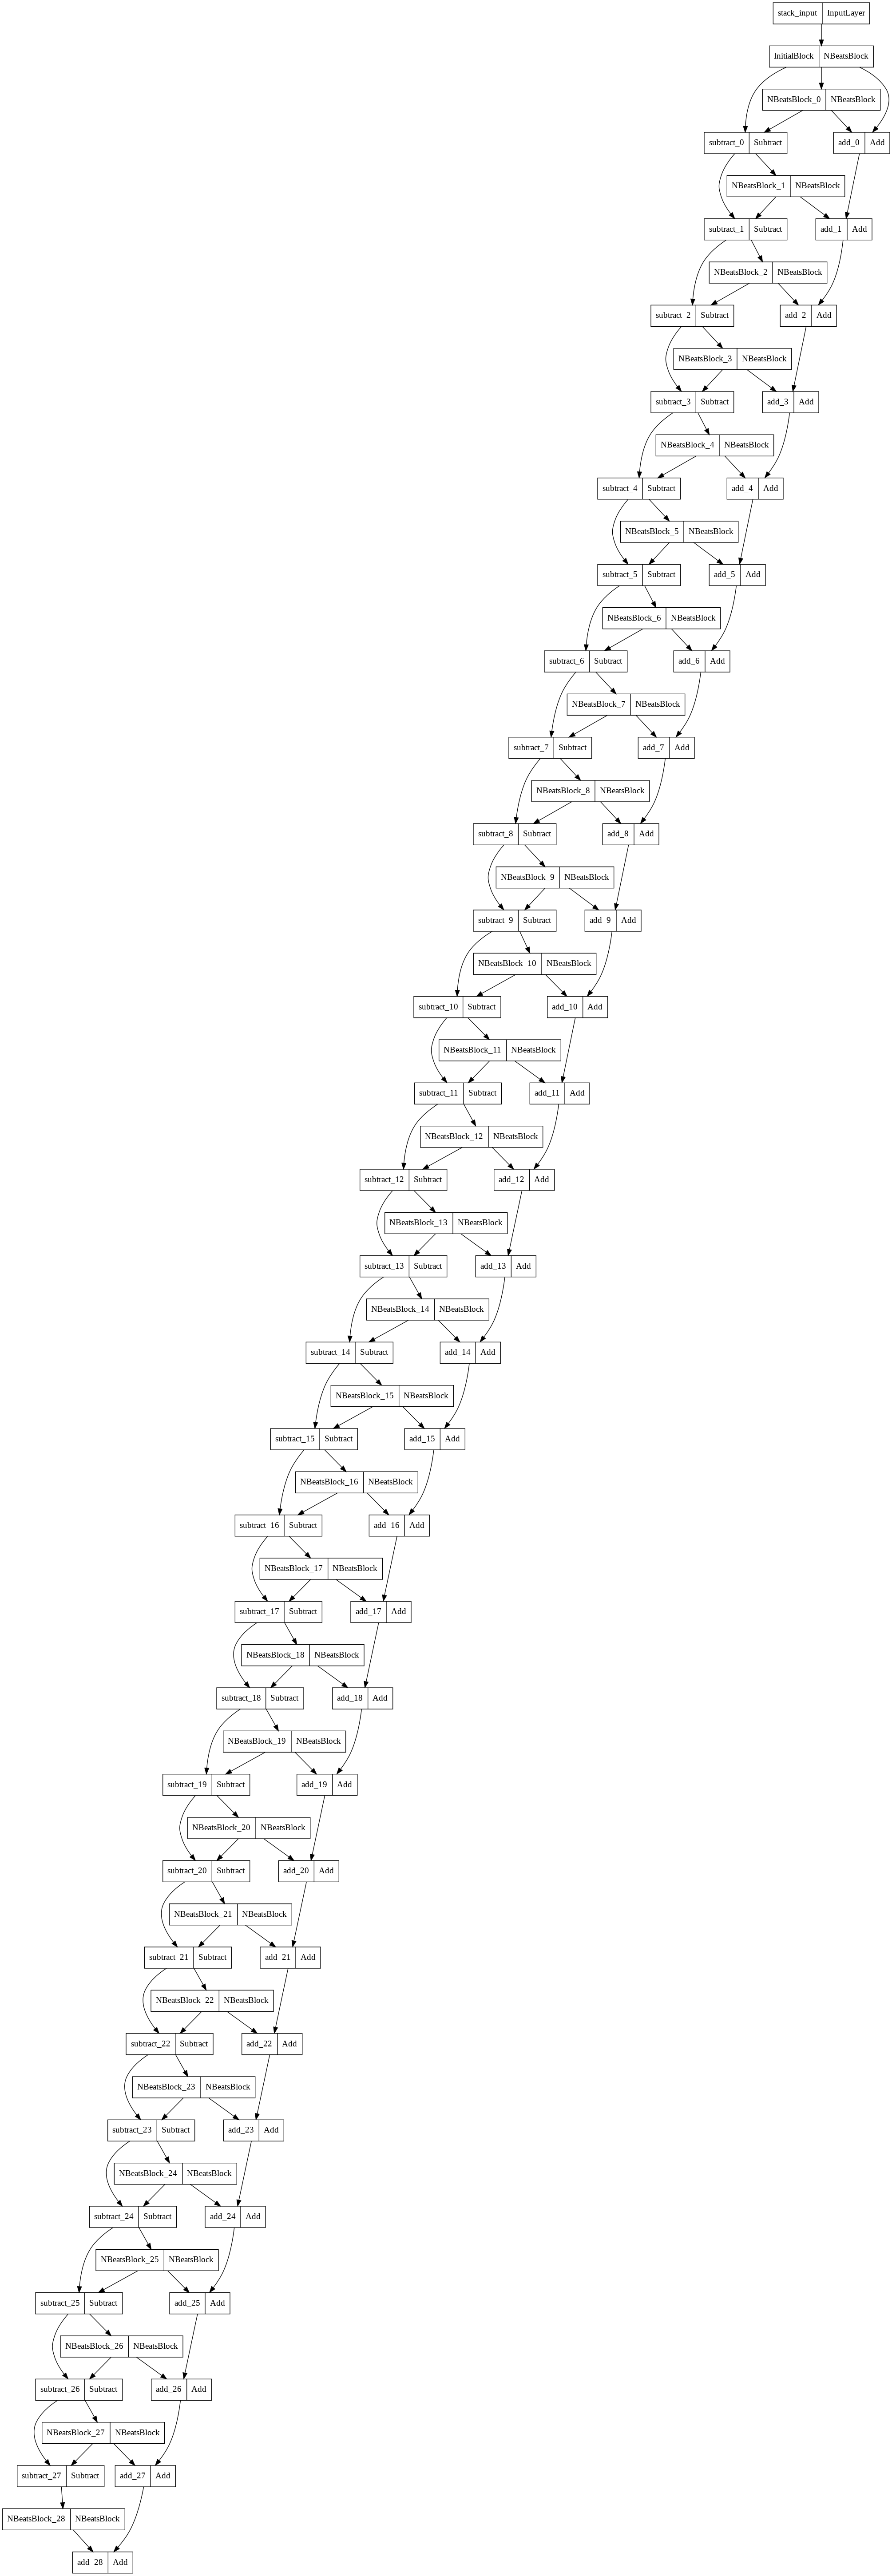

In [116]:
# plot the N-BEATS model and inspect the architecture
plot_model(model_7)

Our N-BEATS model replicates the N-BEATS generic architecture, the training setups are largely the same, except for the N-BEATS paper used an ensemble of models to make predictions (multiple different loss functions and multiple different lookback windows), see Table 18 of the N-BEATS paper for more. An extension could be to setup this kind of training regime and see if it improves performance.

In [117]:
# this will error out unless a "get_config()" method is implemented - this could be extra curriculum
model_7.save(model_7.name)

INFO:tensorflow:Assets written to: model_7_NBEATS/assets


INFO:tensorflow:Assets written to: model_7_NBEATS/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


### Model 8: Creating an ensemble (stacking different models together)

An ensemble involves training and combining multiple *different* models on the same problem.

The benefit of ensembling models is you get the "decision of the crowd effect". Rather than relying on a single model's predictions, you can take the average or median of many different models.

To create our ensemble models we're going to be using a combination of:

* Different loss functions (MAE, MSE, MAPE)
* Randomly initialized models

We'll start by creating a function to produce a list of different models trained with different loss functions. Each layer in the ensemble models will be initialized with a random normal (Gaussian) distribution using [He normal initialization](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal), this'll help estimating the prediction intervals later on.

In [118]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=['mae', 'mse', 'mape']):
  '''
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  '''

  # make an empty list for trained ensemble models
  ensemble_models = []

  # create num_iter number of models per loss function
  for i in range(num_iter):
    # build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f'Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}')

      # construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
              # initialize dense layers with normal distribution for estimating prediction intervals later on                     
              layers.Dense(128, kernel_initializer='he_normal', activation='relu'),
              layers.Dense(128, kernel_initializer='he_normal', activation='relu'),
              layers.Dense(HORIZON, activation='linear')                     
      ])

      # compile simple model with current loss fn
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['mae', 'mse'])
      
      # fit the current model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                patience=100,
                                                                verbose=1)])
      
      # append fitted model to a list of ensemble model
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

In [119]:
%%time
# get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 00793: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 00996: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 00131: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00504: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00604: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 00659: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 00490: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00590: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizi

In [120]:
len(ensemble_models)

15

In [121]:
ensemble_models

In [122]:
# create a function for prediction wich uses a list of models
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [123]:
# make prediction
%%time
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)

CPU times: user 579 ms, sys: 12.9 ms, total: 592 ms
Wall time: 575 ms


In [124]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 9047.843 ,  8902.265 ,  8808.622 ,  9086.259 ,  9519.489 ,
        9455.3955,  9683.61  ,  9448.256 , 10242.298 ,  9615.297 ],
      dtype=float32)>

In [125]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median[:10]

array([ 9046.744 ,  8903.255 ,  8804.143 ,  9085.621 ,  9513.51  ,
        9455.489 ,  9690.612 ,  9447.433 , 10259.6045,  9612.167 ],
      dtype=float32)

In [126]:
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_mean)
ensemble_results

{'mae': 898.6797,
 'mape': 2.636087,
 'mase': 0.9999,
 'mse': 1999254.6,
 'rmse': 1413.95}

In [127]:
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_median)
ensemble_results

{'mae': 896.74713,
 'mape': 2.6294856,
 'mase': 0.9978,
 'mse': 1990903.1,
 'rmse': 1410.9937}

In [128]:
model_6_results

{'mae': 898.09314,
 'mape': 2.6267517,
 'mase': 0.9993,
 'mse': 2004120.8,
 'rmse': 1415.6697}

With our ensemble architecture, we managed to reach slightly better performance. However, the improvement came with a cost of much longer training time.

### Plotting the prediction intervals (uncertainty estimates) of our ensemble

Right now all of our model's (prior to the ensemble model) are predicting single points.

Meaning, given a set of `WINDOW_SIZE=7` values, the model will predict `HORIZION=1`.

But what might be more helpful than a single value?

Perhaps a range of values?

For example, if a model is predicting the price of Bitcoin to be 50,000USD tomorrow, would it be helpful to know it's predicting the 50,000USD because it's predicting the price to be between 48,000USD and 52,000USD?

Knowing the range of values a model is predicting may help you make better decisions for your forecasts.

You'd know that although the model is predicting 50,000USD (a **point prediction**, or single value in time), the value could actually be within the range 48,000USD to 52,000USD

These kind of prediction ranges are called **prediction intervals** or **uncertainty estimates**. And they're often as important as the forecast itself.

Why?

Because point predictions are almost always going to be wrong. So having a range of values can help with decision making.

One way of getting the **95% condfidnece prediction intervals** for a deep learning model is the bootstrap method:

1. Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble model)

2. Measure the standard deviation of the predictions

3. Multiply the standard deviation by 1.96 (assuming the distribution is Gaussian, 95% of observations fall within 1.96 standard deviations of the mean, this is why we initialized our neural networks with a normal distribution)

4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)

In [129]:
# find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. take the predictions of randomly initialized models
  # 2. measure the std of the predictions
  std = tf.math.reduce_std(preds, axis=0)
  # 3. multiply the std by 1.96 (95& confidence interval)
  interval = 1.96 * std
  # 4. get the prediction interval upper & lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

In [130]:
# get the upper & lower bounds of the 95% prediction interval
lower, upper = get_upper_lower(preds=ensemble_preds)

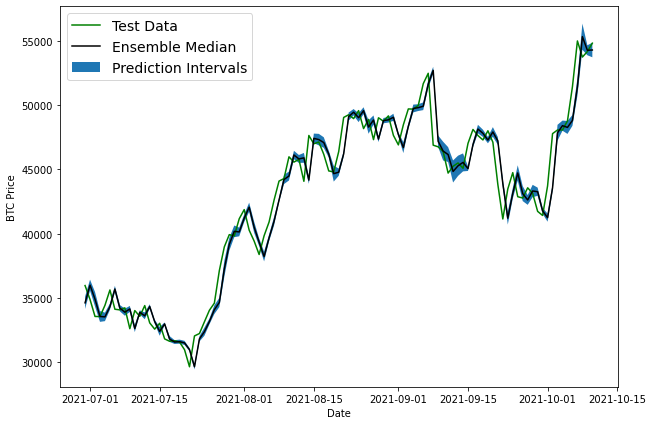

In [132]:
# get the median/mean values of our ensemble preds
ensemble_median = np.mean(ensemble_preds, axis=0)

# plot the median of our ensemble preds with the prediction intervals
offset = 400
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], 'g', label='Test Data')
plt.plot(X_test.index[offset:], ensemble_median[offset:], 'k-', label='Ensemble Median')
plt.xlabel('Date')
plt.ylabel('BTC Price')
# to plot the upper & lower bounds let's use fill_between
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label='Prediction Intervals')
plt.legend(loc='upper_left', fontsize=14);

It looks like the ensemble predictions are lagging slightly behind the actual data.

And the prediction intervals are fairly low throughout.

The combination of lagging predictions as well as low prediction intervals indicates that our ensemble model may be **overfitting** the data, meaning it's basically replicating what a naïve model would do and just predicting the previous timestep value for the next value.

This would explain why previous attempts to beat the naïve forecast have been futile.

We can test this hypothesis of overfitting by creating a model to make predictions into the future and seeing what they look like.

*Our prediction intervals assume that the data we're using come from a Gaussian/normal distribution (also called a bell curve), however, open systems rarely follow the Gaussian.*

### Model 9: Train a model on the full historical data to make predictions into future

It's time we created a model which is able to make future predictions on the price of Bitcoin.

To make predictions into the future, we'll train a model on the full dataset and then get to make predictions to some future horizon.

In [133]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-11-02,325.22633,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-03,331.60083,25,325.22633,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-04,324.71833,25,331.60083,325.22633,NaN,NaN,NaN,NaN,NaN
2014-11-05,332.45666,25,324.71833,331.60083,325.22633,NaN,NaN,NaN,NaN
2014-11-06,336.58500,25,332.45666,324.71833,331.60083,325.22633,NaN,NaN,NaN


In [134]:
# Train model on entire data to make prediction for the next day 
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy() # only want prices, our future model can be a univariate model
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

Windows and labels ready! Let's turn them into performance optimized TensorFlow Datasets by:

1. urning X_all and y_all into tensor Datasets using `tf.data.Dataset.from_tensor_slices()`

2. Combining the features and labels into a Dataset tuple using `tf.data.Dataset.zip()`

3. Batch and prefetch the data using `tf.data.Dataset.batch()` and `tf.data.Dataset.prefetch()` respectively

In [135]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>

And now let's create a model similar to `model_1` except with an extra layer, we'll also fit it to the entire dataset for 100 epochs (feel free to play around with the number of epochs or callbacks here, you've got the skills to now)

In [139]:
tf.random.set_seed(29)

# create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

# compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0) # don't print out anything, we've seen this all before

#### Make predictions on the future

In [137]:
# how many timesteps to predict into the future?
INTO_FUTURE = 14 # since our Bitcoin data is daily, this is for 14 days

Let's create a function which returns INTO_FUTURE forecasted values using a trained model:

To do so, we'll build the following steps:

1. Function which takes as input:
* a list of values (the Bitcoin historical data)
* a trained model (such as `model_9`)
* a window into the future to predict (our `INTO_FUTURE` variable)
* the window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on

2. Creates an empty list for future forecasts (this will be returned at the end of the function) and extracts the last `WINDOW_SIZE` values from the input values (predictions will start from the last `WINDOW_SIZE` values of the training data)

3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` datasets which update to remove the first the value and append the latest prediction


In [145]:
# 1. Create function to make prediction into the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE):
  '''
  Make future forecasts into_future steps after values ends.
  Returns future forecasts as a list of floats.
  '''

  # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each
  for _ in range(INTO_FUTURE):
    # predict on the last window then append it again and again
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f'Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n')

    # append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # update last window with new pred and get WINDOW_SIZE most recent preds
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [146]:
# make forecast into the future
future_forecast = make_future_forecasts(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

Predicting on:
 [48085.04798091 48794.21023815 51459.09282091 55029.874319
 53770.27705841 54203.29831439 54854.87645698] -> Prediction: 48010.01953125

Predicting on:
 [48794.21023815 51459.09282091 55029.874319   53770.27705841
 54203.29831439 54854.87645698 48010.01953125] -> Prediction: 51113.7109375

Predicting on:
 [51459.09282091 55029.874319   53770.27705841 54203.29831439
 54854.87645698 48010.01953125 51113.7109375 ] -> Prediction: 53283.6640625

Predicting on:
 [55029.874319   53770.27705841 54203.29831439 54854.87645698
 48010.01953125 51113.7109375  53283.6640625 ] -> Prediction: 53972.8984375

Predicting on:
 [53770.27705841 54203.29831439 54854.87645698 48010.01953125
 51113.7109375  53283.6640625  53972.8984375 ] -> Prediction: 54078.2265625

Predicting on:
 [54203.29831439 54854.87645698 48010.01953125 51113.7109375
 53283.6640625  53972.8984375  54078.2265625 ] -> Prediction: 52948.796875

Predicting on:
 [54854.87645698 48010.01953125 51113.7109375  53283.6640625
 53

In [147]:
future_forecast[:10]

[48010.02,
 51113.71,
 53283.664,
 53972.9,
 54078.227,
 52948.797,
 51854.535,
 49669.062,
 52515.707,
 53619.582]

#### Plot future forecasts

To plot our model's future forecasts against the historical data of Bitcoin, we're going to need a series of future dates (future dates from the final date of where our dataset ends).

Let's create a function to return a date range from some specified start date to a specified number of days into the future (`INTO_FUTURE`).

In [151]:
def get_future_dates(start_date, into_future, offset=1):
  '''
  Returns array of datetime values ranging from start_date to start_date+into_future
  '''

  start_date = start_date + np.timedelta64(offset, 'D') # specify startdate
  end_date = start_date + np.timedelta64(into_future, 'D') # specify end_date
  return np.arange(start_date, end_date, dtype='datetime64[D]')

In [152]:
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-10-10 00:00:00')

In [154]:
# get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-10-11', '2021-10-12', '2021-10-13', '2021-10-14',
       '2021-10-15', '2021-10-16', '2021-10-17', '2021-10-18',
       '2021-10-19', '2021-10-20', '2021-10-21', '2021-10-22',
       '2021-10-23', '2021-10-24'], dtype='datetime64[D]')

In [158]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-10-10', '2021-10-11', '2021-10-12', '2021-10-13',
        '2021-10-14', '2021-10-15', '2021-10-16', '2021-10-17',
        '2021-10-18', '2021-10-19', '2021-10-20', '2021-10-21',
        '2021-10-22', '2021-10-23', '2021-10-24'], dtype='datetime64[D]'),
 array([54854.875, 48010.02 , 51113.71 , 53283.664, 53972.9  , 54078.227,
        52948.797, 51854.535, 49669.062, 52515.707, 53619.582, 53446.7  ,
        53292.863, 51735.688, 51221.266], dtype=float32))

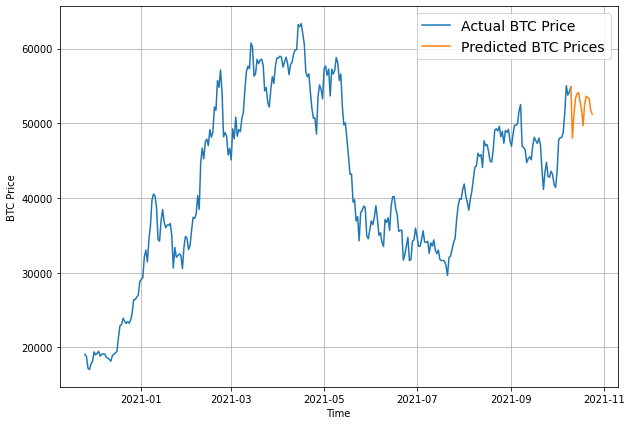

In [159]:
# plot future prices prediction of BTC
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2200, format='-', label='Actual BTC Price')
plot_time_series(next_time_steps, future_forecast, format='-', label='Predicted BTC Prices')

It looks like our predictions are starting to form a bit of a cyclic pattern (up and down in the same way).

Perhaps that's due to our model overfitting the training data and not generalizing well for future data. Also, as you could imagine, the further you predict into the future, the higher your chance for error.

### Model 10: Why forecasting is BS (the turkey problem)

When creating any kind of forecast, you must keep the **turkey problem** in mind.

The **turkey problem** is an analogy for when your observational data (your historical data) fails to capture a future event which is catostrophic and could lead you to ruin.

The story goes, a turkey lives a good life for 1000 days, being fed every day and taken care of by its owners until the evening before Thanksgiving.

Based on the turkey's observational data, it has no reason to believe things shouldn't keep going the way they are.

In other words, how could a turkey possibly predict that on day 1001, after 1000 consectutive good days, it was about to have a far from ideal day.

In [160]:
# let's introduce a turkey problem to our BTC data (price of BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [161]:
# manufacture an extra price on the end
btc_price_turkey[-10:]

[43718.377746744,
 47797.7040332651,
 48083.4372555603,
 48085.0479809108,
 48794.2102381457,
 51459.0928209095,
 55029.8743189991,
 53770.2770584066,
 54203.2983143898,
 548.548764569752]

In [162]:
# get the time steps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-10-01T00:00:00.000000000', '2021-10-02T00:00:00.000000000',
       '2021-10-03T00:00:00.000000000', '2021-10-04T00:00:00.000000000',
       '2021-10-05T00:00:00.000000000', '2021-10-06T00:00:00.000000000',
       '2021-10-07T00:00:00.000000000', '2021-10-08T00:00:00.000000000',
       '2021-10-09T00:00:00.000000000', '2021-10-10T00:00:00.000000000'],
      dtype='datetime64[ns]')

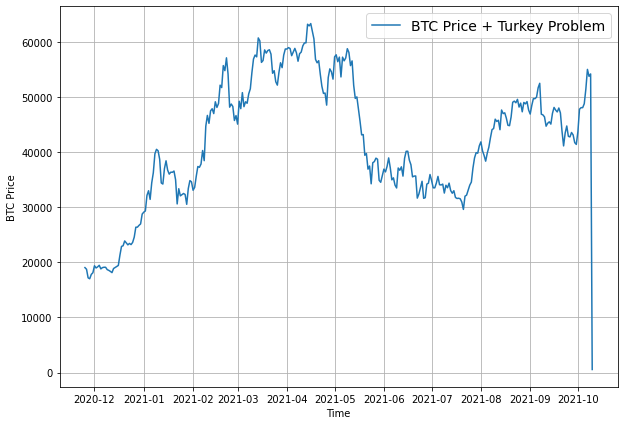

In [163]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey, 
                 values=btc_price_turkey, 
                 format="-", 
                 label="BTC Price + Turkey Problem", 
                 start=2200)

In [ ]:
WINDOW_SIZE = 7
HORIZON = 1

In [164]:
# create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE,
                                         horizon=HORIZON)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2010, 503, 2010, 503)

In [165]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [167]:
# clone model_1 architecture
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = 'model_10_turkey_model'
turkey_model.compile(loss='mae',
                     optimizer=tf.keras.optimizers.Adam())
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 batch_size=128,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


In [168]:
# evaluate model on test data
turkey_model.evaluate(X_test, y_test)

16/16 [==============================] - 0s 2ms/step - loss: 1066.8610


1066.8609619140625

In [169]:
# load best performing turkey model and evaluate it on test data
turkey_model = tf.keras.models.load_model('model_experiments/model_10_turkey_model')
turkey_model.evaluate(X_test, y_test)

16/16 [==============================] - 0s 2ms/step - loss: 1006.1342


1006.1341552734375

In [170]:
# make predictions
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 9089.766,  8925.395,  8835.207,  9081.457,  9470.671,  9475.02 ,
        9688.602,  9478.684, 10198.883,  9639.294], dtype=float32)>

In [171]:
# evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

{'mae': 19797.854,
 'mape': 109.899445,
 'mase': 19.7127,
 'mse': 607305800.0,
 'rmse': 24217.24}

In [172]:
model_1_results

{'mae': 913.9969,
 'mape': 2.680575,
 'mase': 1.017,
 'mse': 2045334.9,
 'rmse': 1430.152}

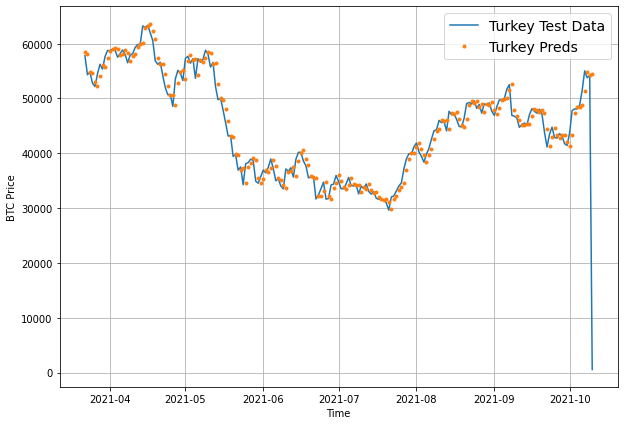

In [173]:
plt.figure(figsize=(10, 7))
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):],
                 format='-',
                 label='Turkey Test Data', start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds, 
                 label="Turkey Preds", 
                 start=offset);

A model cannot predict anything in the future outside of the distribution it was trained on.

In turn, highly unlikely price movements (based on historical movements), upward or downward will likely never be part of a forecast.

However, as we've seen, despite their unlikeliness, these events can have huge impacts to the performance of our models.

### Compare Models

In [174]:
# compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_8_NBEATs": model_7_results,
                              "model_9_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,897.235413,1.978848e+06,1406.715454,2.629933,0.9983
model_1_dense_w7_h1,913.996887,2.045335e+06,1430.151978,2.680575,1.0170
model_2_dense_w30_h1,965.126526,2.206056e+06,1485.279785,2.797222,1.0657
model_3_dense_w30_h7,2006.178467,9.856291e+06,2303.669434,5.759022,2.2283
model_4_CONV1D,912.773132,2.049930e+06,1431.757446,2.668836,1.0156
model_5_LSTM,916.211304,2.054803e+06,1433.458374,2.684088,1.0194
model_6_multivariate,898.093140,2.004121e+06,1415.669678,2.626752,0.9993
model_8_NBEATs,900.179199,2.011063e+06,1418.119507,2.633710,1.0016
model_9_ensemble,896.747131,1.990903e+06,1410.993652,2.629486,0.9978
model_10_turkey,19797.853516,6.073058e+08,24217.240234,109.899445,19.7127


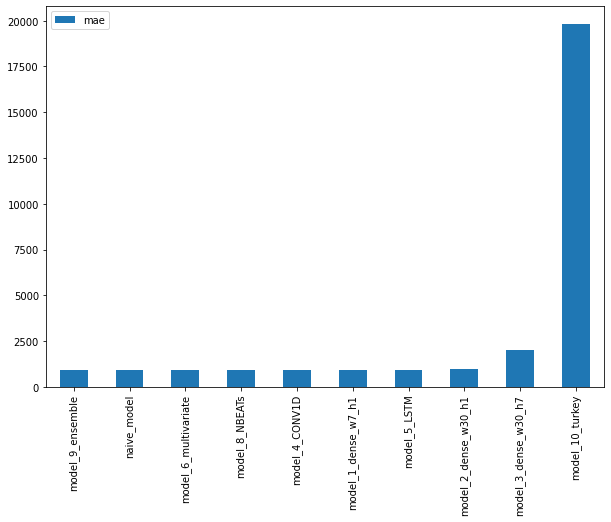

In [175]:
# sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");

The majority of our deep learning models perform on par or only slightly better than the naive model. And for the turkey model, changing a single data point destroys its performance.

During the course of the project, we learned that time series forecasting for open systems doesn't perform well. However, forecasting in a closed system (such as predicting the demand of electricity) often yields quite usable results.